## Подготовка данных

In [135]:
# импортируем бибилиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from myhelp.excel_out import exel_out_clip as exo
from sklearn.model_selection import train_test_split

In [136]:
# загружаем данные

# тренировочные данные
data = pd.read_csv('E:/Projects/Python/MyPython/kaggle/titanic/data/train.csv',
                   sep=',', encoding='utf8')

# тестовые данные
test_data = pd.read_csv('E:/Projects/Python/MyPython/kaggle/titanic/data/test.csv',
                        sep=',', encoding='utf8')

# объединяем данные(тестовые данные и тренировочные) в один файл
all_data = pd.concat([data, test_data], axis=0, ignore_index=True)


In [137]:
# посмотрим на первые 5 строк данных
all_data[:5]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [138]:
# выводим информацию о данных
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 97.2+ KB


In [139]:
# как видим имеются пропущенные значения в данных, посчитаем их количество
print('Отсутсвующие элементы в тренировочных данных:\n\n ', data.isnull().sum())
print('-'*100)
print('\nОтсутсвующие элементы в тестовых данных:\n\n', data.isnull().sum())

Отсутсвующие элементы в тренировочных данных:

  PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------------------------------------------------------------------

Отсутсвующие элементы в тестовых данных:

 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [140]:
# пустые значения нужно заполнять (брать просто средний возраст некорректно,
# возраст зависит от титула, возможно от пола и(или) от класса)

# посмотрим первые 10 списков титулов
all_data.Name.head(10)


0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

##### Name

In [141]:
# каждое имя имеет статус, как по мне так это очень важный предиктор в задаче
# проставим титула (разобьем по запятой)

def replace_name(atr):
    
    '''функция выделения титулов из имен'''
    return atr.split(',')[1].split('.')[0].strip()


try:
    # получаем список очищенный от имен список титулов
    all_data.Name = [replace_name(x) for x in all_data.Name]
    print('Имена отридактированы')
except IndexError:
    print('Имена уже были отридактированы')
    

Имена отридактированы


In [142]:
# посмотрим на результат
all_data.Name.value_counts()
# как видим наибольшие значния Mr, Miss, Mrs, Master
# выделим их в отдельные группы, остальных поместим в others

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Dona              1
Jonkheer          1
Sir               1
Capt              1
Don               1
the Countess      1
Lady              1
Mme               1
Name: Name, dtype: int64

In [143]:
def agr_name(tit):
    
    '''функция группирования титулов '''
    
    if tit == 'Mlle' or tit == 'Miss':
        tit = 'Miss'
    elif tit == 'Mme' or tit == 'Lady' or tit == 'Ms' or tit == 'Mrs':
        tit = 'Mrs'
    elif tit == 'Master':
        tit = 'Master'
    elif tit == 'Mr':
        tit = 'Mr'
    elif tit != 'Miss' or tit != 'Mrs' or tit != 'Mr' or tit != 'Master':
        tit = 'Other'
    return tit


# группируем титулы в дате
print('-'*100)   
all_data.Name = [agr_name(x) for x in all_data.Name]
# выведем подсчет уникальных значений
all_data.Name.value_counts()

----------------------------------------------------------------------------------------------------


Mr        757
Miss      262
Mrs       201
Master     61
Other      28
Name: Name, dtype: int64

##### Sex

In [144]:
# переходим к предиктору "пол"

# посмотрим долю выживаемости мужчин и женщин
print(all_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

# процент выживаемости у женщин значительтно выше

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [145]:
# доля выживаемости по полу и классу
all_data.groupby(["Pclass", "Sex"])["Survived"].value_counts(normalize=True)
# процент выживаемости женщин первого класса составляет ~97%, второго класса ~96%, третьего ~50%
# начинает высрисовываться картина

Pclass  Sex     Survived
1       female  1.0         0.968085
                0.0         0.031915
        male    0.0         0.631148
                1.0         0.368852
2       female  1.0         0.921053
                0.0         0.078947
        male    0.0         0.842593
                1.0         0.157407
3       female  0.0         0.500000
                1.0         0.500000
        male    0.0         0.864553
                1.0         0.135447
Name: Survived, dtype: float64

##### Family 

In [146]:
# создадим новый предиктор (семья) суммой родителей, братьев и систер и сам пассажир
all_data['Family'] = all_data.SibSp + all_data.Parch + 1
# посмотрим зависимость кол-во людей в семье на выживаемость
print(all_data[['Family', 'Survived']].groupby(['Family'], as_index=False).mean())
# зависимость присутствует, тем меньше людей на корабле, тем вероятность выжить меньше
# также, если семья имеет 5 и выше людей, то вероятность выживания резко падает

   Family  Survived
0       1  0.303538
1       2  0.552795
2       3  0.578431
3       4  0.724138
4       5  0.200000
5       6  0.136364
6       7  0.333333
7       8  0.000000
8      11  0.000000


In [147]:
# посмотрим кол-во семей в зависимости от кол-ва людей в семье
all_data.Family.value_counts()
# в основном пассажиры находились на Титанике в одиночке

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

In [148]:
# разделим семьи на 5 групп (|от 0 до 4|, 0=(11,8), 1=(1, 5, 6, 7), 2=(2), 3=(3), 4=(4))
def agr_family(count_family):
    
    '''функция группирования семьи'''
    if count_family == 11 or count_family == 8:
        count_family = 0
    elif count_family == 1 or count_family == 5 or count_family == 6 or count_family == 7:
        count_family = 1
    elif count_family == 2:
        count_family = 2
    elif count_family == 3:
        count_family = 3
    elif count_family == 4:
        count_family = 4
    return count_family
    

# присваеваем группированные значения
all_data.Family = [agr_family(x) for x in all_data.Family]

# смотрим на выживаемость по новой группе
print(all_data[['Family', 'Survived']].groupby(['Family'], as_index=False).mean())

   Family  Survived
0       0  0.000000
1       1  0.295222
2       2  0.552795
3       3  0.578431
4       4  0.724138


In [149]:
# смотрим как получилось (подсчитываем кол-во уникальных значений)
all_data.Family.value_counts()

1    853
2    235
3    159
4     43
0     19
Name: Family, dtype: int64

##### Fare

In [150]:
# Количество отсутствующих значений в цене билета
all_data.Fare.isnull().sum(axis=0)

1

In [151]:
# нулевые значения в цене билета в зависимоти от титула    
print('Кол-во нулевых билетов: ' + str(all_data.Fare[all_data.Fare == 0].value_counts()))

# выводим значения
all_data.query('Fare == 0')

Кол-во нулевых билетов: 0.0    17
Name: Fare, dtype: int64


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family
179,36.0,NaN,S,0.0,Mr,0,180,3,male,0,0.0,LINE,1
263,40.0,B94,S,0.0,Mr,0,264,1,male,0,0.0,112059,1
271,25.0,NaN,S,0.0,Mr,0,272,3,male,0,1.0,LINE,1
277,NaN,NaN,S,0.0,Mr,0,278,2,male,0,0.0,239853,1
302,19.0,NaN,S,0.0,Mr,0,303,3,male,0,0.0,LINE,1
413,NaN,NaN,S,0.0,Mr,0,414,2,male,0,0.0,239853,1
466,NaN,NaN,S,0.0,Mr,0,467,2,male,0,0.0,239853,1
481,NaN,NaN,S,0.0,Mr,0,482,2,male,0,0.0,239854,1
597,49.0,NaN,S,0.0,Mr,0,598,3,male,0,0.0,LINE,1
633,NaN,NaN,S,0.0,Mr,0,634,1,male,0,0.0,112052,1


In [152]:
# как видно по таблице нулевая стоимость была у всех мужчин, также в основном неизвестен их возраст,
# но согласно титулам мы можем сказать что это не дети, поэтому нужно дополнить нулевые значения

# логично предположить что стоимость билета зависит от класса, проверим:
mean_fare = all_data.query('Fare != 0')[['Pclass', 'Fare']].groupby(['Pclass']).mean()
print(mean_fare)
# так и есть, попробуем заполнить нулевые значения согласно классам пассажира

             Fare
Pclass           
1       89.447482
2       21.648108
3       13.378473


In [153]:
# заменяем недостающее значение, которые выявили ранее
# по нему проставится среднее значение по классу
all_data.loc[all_data.Fare.isnull(), 'Fare'] = 0

# заменяем все нулевые значения средними значения по классам
all_data.loc[(all_data.Fare == 0) & (all_data.Pclass == 1), 'Fare'] = float(mean_fare.loc[1])
all_data.loc[(all_data.Fare == 0) & (all_data.Pclass == 2), 'Fare'] = float(mean_fare.loc[2])
all_data.loc[(all_data.Fare == 0) & (all_data.Pclass == 3), 'Fare'] = float(mean_fare.loc[3])

##### Age

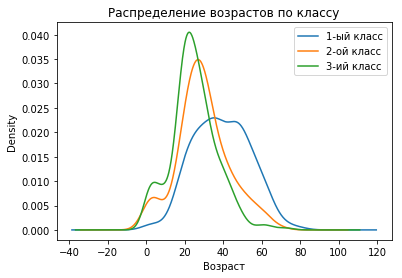

In [154]:
# возраст один из самых выжных фич, около 20% всей выборки пропущен возраст
# необходимо максимально корректно заполнить пропуска
# (по предыдущем решениям в основном нейросеть путалась имеено в заполненых значениях возрастов)

# посмотрим на распределение возрастов от класса
all_data.Age[all_data.Pclass == 1].plot(kind='kde')    
all_data.Age[all_data.Pclass == 2].plot(kind='kde')
all_data.Age[all_data.Pclass == 3].plot(kind='kde')
plt.xlabel("Возраст")
plt.title("Распределение возрастов по классу")
plt.legend(('1-ый класс', '2-ой класс','3-ий класс'),loc='best')

# как видно из графика разброс по возрасту 3-ьего класса был минимальным, в то время как 1-ого класса приличным
# это хорошо, так как это нам поможет в проставлении корректного значения пассажирам третьего класса,
# так как недостаток информации наблюдается именно по третьему классу

In [155]:
# логично предположить что возрас будет коррелировать с титулом
# посмотрим на зависимость возраста по титулу
mean_age = all_data[['Name', 'Age']].groupby(['Name']).mean()
print(mean_age)

              Age
Name             
Master   5.482642
Miss    21.795236
Mr      32.252151
Mrs     36.930636
Other   45.074074


In [156]:
# проставим пропускные значения возраста согласано титулам
all_data.loc[all_data.Age.isnull(), 'Age'] = 0
all_data.loc[(all_data.Age == 0) & (all_data.Name == 'Master'), 'Age'] = float(mean_age.loc['Master'])
all_data.loc[(all_data.Age == 0) & (all_data.Name == 'Miss'), 'Age'] = float(mean_age.loc['Miss'])
all_data.loc[(all_data.Age == 0) & (all_data.Name == 'Mr'), 'Age'] = float(mean_age.loc['Mr'])
all_data.loc[(all_data.Age == 0) & (all_data.Name == 'Mrs'), 'Age'] = float(mean_age.loc['Mrs'])
all_data.loc[(all_data.Age == 0) & (all_data.Name == 'Other'), 'Age'] = float(mean_age.loc['Other'])

In [157]:
# снова проверяем что получилось, видим что все четенько
mean_age = all_data[['Name', 'Age']].groupby(['Name']).mean()

print(mean_age)

              Age
Name             
Master   5.482642
Miss    21.795236
Mr      32.252151
Mrs     36.930636
Other   45.074074


In [158]:
# сформируем возрастную группу
all_data.loc[ all_data['Age'] <= 16, 'Age'] = 0
all_data.loc[(all_data['Age'] > 16) & (all_data['Age'] <= 32), 'Age'] = 1
all_data.loc[(all_data['Age'] > 32) & (all_data['Age'] <= 48), 'Age'] = 2
all_data.loc[(all_data['Age'] > 48) & (all_data['Age'] <= 64), 'Age'] = 3
all_data.loc[ all_data['Age'] > 64, 'Age'] = 4 ;

##### Cabin

In [159]:
# заменяем пропускные знаяения 'Z'
# отберем только первые буквы кабин и посмотрим на зависимось
# (сам бы кабины я не включил в анализ,
# но в виду того что нихрена не выходило набрать свыше 80% включим их)

# не знаю о чем говорит первая отобранный символ билета, увидел это в другом решении и чувака

# проставляем где отсутсвует 'Z'
all_data.Cabin.fillna('Z',inplace=True)

# отбираем первый символ кабины
all_data['Cabin'] = all_data['Cabin'].map(lambda x : x[0])

# считаем уникальные значения
all_data['Cabin'].value_counts()

print(all_data[:891][['Cabin', 'Survived']].groupby(['Cabin']).mean())
print('-'*10)
# количество
print(all_data[:891]['Cabin'].value_counts())

# как видим зависимость есть, причем достаточно сильная
# в билетах, начинающихся на B,D,E - шанс на выживание резко увеличивается

       Survived
Cabin          
A      0.466667
B      0.744681
C      0.593220
D      0.757576
E      0.750000
F      0.615385
G      0.500000
T      0.000000
Z      0.299854
----------
Z    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64


In [160]:
def agr_cabin(cabin):
    
    '''функция агрегированя и приведение в числовой тип cabin'''
    
    if cabin  == 'Z' or cabin == 'T':
        cabin = 0
    elif cabin == 'A' or cabin == 'G':
        cabin = 3
    elif cabin == 'C':
        cabin = 4
    elif cabin == 'F':
        cabin = 5
    elif cabin == 'B' or cabin == 'D' or cabin == 'E':
        cabin = 6
    else:
        cabin = 'no'
    return cabin

In [161]:
# присваеваем группированные значения
all_data.Cabin = [agr_cabin(x) for x in all_data.Cabin]

##### IsALone

In [162]:
# создадим дополнительный столбец (один или нет пассажир)

all_data['isAlone'] = 0
all_data.loc[all_data['Family'] == 1, 'isAlone'] = 1

##### Краткая сводка

In [163]:
# Итак прикинем что сделали:
# Какаие независимые переменные будем использовать

# 1-Класс
# 2-Пол
# 3-Титул
# 4-Возраст
# 5-Семья
# 6-Стоимость билета
# 7-Кабины

# Нам осталось нормировать данные, привести их от 0,1 до 0,99

# Для большинства моделей нормировать данные не обязательно,
# но сделаем это, в виду того что будем юзать нейронки и SVM

# Для этого нуджно все предикторы привести в числовой тип, давайте сделаем это

##### Нормирование данных

In [164]:
# опишем функцию нормирования данных
def norm_data(val, min_val, max_val):
    '''функция нормирования данных'''
    min_lim = 0.01
    max_lim = 0.99
    return (((max_lim - min_lim)*(val-min_val)/(max_val-min_val)+min_lim))

In [165]:
# проставим пол
# male - 0, female - 1
try:
    all_data.Sex.replace(['male', 'female'], [0,1], inplace=True)
except TypeError:
    print('Проставлен числовой тип')
    
# нормируем данные пола
max_val = max(all_data.Sex)
min_val = min(all_data.Sex)
all_data.Sex = [norm_data(x, min_val, max_val) for x in all_data.Sex]

In [166]:
# проставим титул
try:
    all_data.Name.replace(['Mr', 'Other', 'Master', 'Miss', 'Mrs'], [0,1,2,3,4], inplace=True)
except TypeError:
    print('Проставлен числовой тип')
    
# нормируем данные титулов
max_val = max(all_data.Name)
min_val = min(all_data.Name)
all_data.Name = [norm_data(x, min_val, max_val) for x in all_data.Name]

In [167]:
# нормируем данные класса
max_val = max(all_data.Pclass)
min_val = min(all_data.Pclass)
all_data.Pclass = [norm_data(x, min_val, max_val) for x in all_data.Pclass]

In [168]:
# нормируем данные семьи
max_val = max(all_data.Family)
min_val = min(all_data.Family)
all_data.Family = [norm_data(x, min_val, max_val) for x in all_data.Family]

In [169]:
# нормируем данные возраста
max_val = max(all_data.Age)
min_val = min(all_data.Age)
all_data.Age = [norm_data(x, min_val, max_val) for x in all_data.Age]

In [170]:
# нормируем стоимость билетов
max_val = max(all_data.Fare)
min_val = min(all_data.Fare)
all_data.Fare = [norm_data(x, min_val, max_val) for x in all_data.Fare]

In [171]:
# нормируем кабины
max_val = max(all_data.Cabin)
min_val = min(all_data.Cabin)
all_data.Cabin = [norm_data(x, min_val, max_val) for x in all_data.Cabin]

In [172]:
# нормируем место посадки пассажиров

# там где отсутсвие, проставим место отправки 'S', так как он самы частый
all_data.loc[all_data.Embarked.isnull(), 'Embarked'] = 'S'

# проставим место отправки
try:
    all_data.Embarked.replace(['S', 'Q', 'C'], [0,1,2], inplace=True)
except TypeError:
    print('Проставлен числовой тип')

# нормируем место отправки
max_val = max(all_data.Embarked)
min_val = min(all_data.Embarked)
all_data.Embarked = [norm_data(x, min_val, max_val) for x in all_data.Embarked]

In [173]:
# нормируем isAlone
max_val = max(all_data.isAlone)
min_val = min(all_data.isAlone)
all_data.isAlone = [norm_data(x, min_val, max_val) for x in all_data.isAlone]
all_data[['isAlone','Survived']].groupby(['Survived']).mean()

,isAlone
Survived,
0.0,0.747231
1.0,0.505731


In [174]:
# итак смотрим на данные 10 первых строк
all_data[:10]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family,isAlone
0,0.255,0.010000,0.01,0.017851,0.010,0,1,0.99,0.01,1,0.0,A/5 21171,0.500,0.01
1,0.500,0.663333,0.99,0.141099,0.990,0,2,0.01,0.99,1,1.0,PC 17599,0.500,0.01
2,0.255,0.010000,0.01,0.019151,0.745,0,3,0.99,0.99,0,1.0,STON/O2. 3101282,0.255,0.99
3,0.500,0.663333,0.01,0.106101,0.990,0,4,0.01,0.99,1,1.0,113803,0.500,0.01
4,0.500,0.010000,0.01,0.019391,0.010,0,5,0.99,0.01,0,0.0,373450,0.255,0.99
5,0.500,0.010000,0.50,0.020177,0.010,0,6,0.99,0.01,0,0.0,330877,0.255,0.99
6,0.745,0.990000,0.01,0.103719,0.010,0,7,0.01,0.01,0,0.0,17463,0.255,0.99
7,0.010,0.010000,0.01,0.044461,0.500,1,8,0.99,0.01,3,0.0,349909,0.255,0.99
8,0.255,0.010000,0.01,0.025326,0.990,2,9,0.99,0.99,0,1.0,347742,0.745,0.01
9,0.010,0.010000,0.99,0.061776,0.990,0,10,0.50,0.99,1,1.0,237736,0.500,0.01


In [175]:
# как видно по таблице мы не взяли только "Ticket"
# отбираем нужные фичи
need_data = all_data[['Name', 'Pclass', 'Age', 'Sex', 'Fare', 'Family', 'Embarked', 'Cabin', 'Survived', 'isAlone']]
need_data[:10]


,Name,Pclass,Age,Sex,Fare,Family,Embarked,Cabin,Survived,isAlone
0,0.010,0.99,0.255,0.01,0.017851,0.500,0.01,0.010000,0.0,0.01
1,0.990,0.01,0.500,0.99,0.141099,0.500,0.99,0.663333,1.0,0.01
2,0.745,0.99,0.255,0.99,0.019151,0.255,0.01,0.010000,1.0,0.99
3,0.990,0.01,0.500,0.99,0.106101,0.500,0.01,0.663333,1.0,0.01
4,0.010,0.99,0.500,0.01,0.019391,0.255,0.01,0.010000,0.0,0.99
5,0.010,0.99,0.500,0.01,0.020177,0.255,0.50,0.010000,0.0,0.99
6,0.010,0.01,0.745,0.01,0.103719,0.255,0.01,0.990000,0.0,0.99
7,0.500,0.99,0.010,0.01,0.044461,0.255,0.01,0.010000,0.0,0.99
8,0.990,0.99,0.255,0.99,0.025326,0.745,0.01,0.010000,1.0,0.01
9,0.990,0.50,0.010,0.99,0.061776,0.500,0.99,0.010000,1.0,0.01


## Машинное обучение

In [176]:
# итак данные готовы, переходим к моделям машинного обучения библиотеки sklearn

In [177]:
# импортируем библиотеки

import sklearn.datasets
import mglearn
from sklearn.model_selection import train_test_split

In [178]:
# формируем данные

#[['Name', 'Pclass', 'Age', 'Sex', 'Fare', 'Family', 'Embarked', 'Cabin']]
# можно удалять что считаете не нужным
train_data = need_data[['Name', 'Pclass', 'Age', 'Sex', 'Fare', 'Family', 'Embarked', 'Cabin', 'isAlone']][:891]
test_data = need_data[['Name', 'Pclass', 'Age', 'Sex', 'Fare', 'Family', 'Embarked', 'Cabin', 'isAlone']][891:]
target_data = need_data['Survived'][:891]

# записываем в объект Brunch нашу дату (тренировочную)
train_brunch = sklearn.datasets.base.Bunch(data=train_data, target=target_data)

# записываем в объект Brunch нашу дату (тестувую)
test_brunch = sklearn.datasets.base.Bunch(data=test_data, target=0)

In [179]:
# параметры модели

# размерность локального тестового набора данных
test_size = 0.15

In [180]:
# разбиваем выборку тренировочных данных на обучающую и локально тестувую

X_train, X_test, y_train, y_test = train_test_split(
train_brunch['data'], train_brunch['target'], train_size = (1- test_size), test_size = test_size)

In [181]:
# # посмотрим на наши данные в диаграмме рассеивания

# # создаем матрицу рассеяния из dataframe, цвет точек задаем с помощью y_train
# grr = pd.plotting.scatter_matrix(train_data, c=target_data, figsize=(15, 15), marker='o',
# hist_kwds={'bins': 20}, s=60, alpha=.8, cmap=mglearn.cm3)

##### KNN

In [182]:
# импортируем класс
from sklearn.neighbors import KNeighborsClassifier

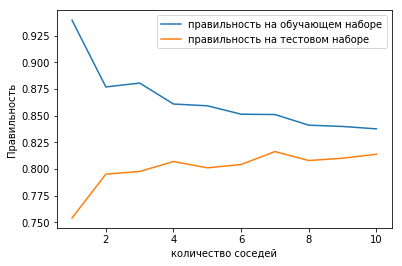

In [183]:
# постараемся найти оптимальное кол-во соседей

# мы могли бы просто прогнать одним циклом кол-во соседей, а затем
# выбрать из тестовых файлов наилучший, однако я считаю это неверным, 
# т.к. тестовая выборка может быть нерепрезентативной, для этого
# запустим еще один цикл по разбивке и на каждой итерации посмотрим результат,
# затем усредним его и выведем на график для отбора наиболее устойчивых параметров

# сюда будут попадать уже усредненые значения
training_accuracy = []
test_accuracy = []

# возьмем кол-во соседей от 1 до 10 
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # записываем каждое решение для последующего усреднения
    training_accuracy_avg = []
    test_accuracy_avg = []
    # кол-во прогонов по тестовым выборкам с разным разбиением
    for _ in range(1,25):
        X_train, X_test, y_train, y_test = train_test_split(
        train_brunch['data'], train_brunch['target'], train_size = (1- test_size), test_size = test_size)
        # строим модель
        knn_optima = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn_optima.fit(X_train, y_train)
        training_accuracy_avg.append(knn_optima.score(X_train, y_train))
        test_accuracy_avg.append(knn_optima.score(X_test, y_test))
    # записываем правильность на обучающем наборе
    training_accuracy.append(np.mean(training_accuracy_avg))
    # записываем правильность на тестовом наборе
    test_accuracy.append(np.mean(test_accuracy_avg))
    
plt.plot(neighbors_settings, training_accuracy, label="правильность на обучающем наборе")
plt.plot(neighbors_settings, test_accuracy, label="правильность на тестовом наборе")
plt.ylabel("Правильность")
plt.xlabel("количество соседей")
plt.legend()

In [184]:
# смотрим где наиболее оптимально кол-во соседей
print('Максимальный результат при кол-ве: ' + str(np.argmax(test_accuracy)+1))
print('Значение: ' + str(np.max(test_accuracy)))

Максимальный результат при кол-ве: 7
Значение: 0.8162313432835822


In [185]:
# согласно тесту, ставим соответствующее значение в объект knn(n_neighbors)

# создаем экземпляр модели
knn = KNeighborsClassifier(n_neighbors=11)
# обучаем модель k-ближайших соседей
knn.fit(X_train, y_train)
# смотрим результат
print('Правильность на тестовом наборе KNN: ' + str(knn.score(X_test, y_test)))

Правильность на тестовом наборе KNN: 0.7835820895522388


##### Логистическая регрессия

In [186]:
from sklearn.linear_model import LinearRegression
# создаем экземпляр модели
lr = LinearRegression()
# обучаем модель
lr.fit(X_train, y_train)
# смотрим результат
# print('Правильность на тестовом наборе KNN: ' + str(lr.score(X_test, y_test)))
print('Правильность на обучающем наборе KNN: ' + str(np.mean(np.round(lr.predict(X_train))==y_train)))
print('Правильность на тестовом наборе KNN: ' + str(np.mean(np.round(lr.predict(X_test))==y_test)))

Правильность на обучающем наборе KNN: 0.8163804491413474
Правильность на тестовом наборе KNN: 0.8059701492537313


##### Гребневая регрессия

In [187]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
print('Правильность на обучающем наборе:' + str(np.mean(np.round(ridge.predict(X_train))==y_train)))
print('Правильность на тестовом наборе:' + str(np.mean(np.round(ridge.predict(X_test))==y_test)))

Правильность на обучающем наборе:0.8058124174372523
Правильность на тестовом наборе:0.7910447761194029


##### Логистическая регрессия

In [188]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=5)
logreg.fit(X_train, y_train)

print('Правильность на обучающем наборе:' + str(np.mean(np.round(logreg.predict(X_train))==y_train)))
print('Правильность на тестовом наборе:' + str(np.mean(np.round(logreg.predict(X_test))==y_test)))

Правильность на обучающем наборе:0.8282694848084544
Правильность на тестовом наборе:0.7761194029850746


##### SVM (линейный)

In [189]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, y_train)

print('Правильность на обучающем наборе:' + str(np.mean(np.round(svc.predict(X_train))==y_train)))
print('Правильность на тестовом наборе:' + str(np.mean(np.round(svc.predict(X_test))==y_test)))

Правильность на обучающем наборе:0.8150594451783355
Правильность на тестовом наборе:0.7910447761194029


##### NAIVE BAYES

In [190]:
from sklearn.naive_bayes import GaussianNB

gsNB = GaussianNB()
gsNB.fit(X_train, y_train)

print('Правильность на обучающем наборе:' + str(np.mean(np.round(gsNB.predict(X_train))==y_train)))
print('Правильность на тестовом наборе:' + str(np.mean(np.round(gsNB.predict(X_test))==y_test)))

Правильность на обучающем наборе:0.7873183619550859
Правильность на тестовом наборе:0.7686567164179104


##### Decision Tree

In [191]:
from sklearn.tree import DecisionTreeClassifier

# хоть деревья решений склонны к переобучению и имеют достаточно низкую обобщая способность посмотрим на них,
# после чего перейдем к самому интересному

tree = DecisionTreeClassifier(random_state=0,max_depth=3)
tree.fit(X_train, y_train)

print('Правильность на обучающем наборе:' + str(np.mean(np.round(tree.predict(X_train))==y_train)))
print('Правильность на тестовом наборе:' + str(np.mean(np.round(tree.predict(X_test))==y_test)))
print('-'*50)
# сформируем важности признаков
for name, score in zip(X_train.keys(), tree.feature_importances_):
    print(name, np.round(score*100,2))

Правильность на обучающем наборе:0.8322324966974901
Правильность на тестовом наборе:0.8208955223880597
--------------------------------------------------
Name 59.94
Pclass 20.84
Age 0.0
Sex 0.0
Fare 11.3
Family 0.0
Embarked 0.0
Cabin 7.93
isAlone 0.0


##### Random Forest

In [192]:
from sklearn.ensemble import RandomForestClassifier

# создадим заново тренировочную и тестувую выборки

X_train, X_test, y_train, y_test = train_test_split(
train_brunch['data'], train_brunch['target'], train_size = (1- test_size), test_size = test_size)

forest = RandomForestClassifier(n_estimators=1000, max_features=3, random_state=0, max_depth=10)
forest.fit(X_train, y_train)

print('Правильность на обучающем наборе:' + str(np.mean(np.round(forest.predict(X_train))==y_train)))
print('Правильность на тестовом наборе:' + str(np.mean(np.round(forest.predict(X_test))==y_test)))
print('-'*50)
# сформируем важности признаков
for name, score in zip(X_train.keys(), forest.feature_importances_):
    print(name, np.round(score*100,2))
    

Правильность на обучающем наборе:0.9471598414795245
Правильность на тестовом наборе:0.7686567164179104
--------------------------------------------------
Name 24.07
Pclass 8.98
Age 6.4
Sex 16.09
Fare 24.98
Family 5.73
Embarked 3.78
Cabin 8.26
isAlone 1.72


In [193]:
# оптимизация параметров для случайного леса

# # сюда будут попадать уже усредненые значения
# training_accuracy = []
# test_accuracy = []

# optima_parameter = range(1, 8)
# for optima in optima_parameter:
#     # записываем каждое решение для последующего усреднения
#     training_accuracy_avg = []
#     test_accuracy_avg = []
#     # кол-во прогонов по тестовым выборкам с разным разбиением
#     for _ in range(1,20):
#         X_train, X_test, y_train, y_test = train_test_split(
#         train_brunch['data'], train_brunch['target'], train_size = (1- test_size), test_size = test_size)
#         # строим модель
#         forest_optima = RandomForestClassifier(n_estimators=200, max_features=3, random_state=0, max_depth=4)
#         forest_optima.fit(X_train, y_train)
#         training_accuracy_avg.append(forest_optima.score(X_train, y_train))
#         test_accuracy_avg.append(forest_optima.score(X_test, y_test))
#     # записываем правильность на обучающем наборе
#     training_accuracy.append(np.mean(training_accuracy_avg))
#     # записываем правильность на тестовом наборе
#     test_accuracy.append(np.mean(test_accuracy_avg))
    
# plt.plot(optima_parameter, training_accuracy, label="правильность на обучающем наборе")
# plt.plot(optima_parameter, test_accuracy, label="правильность на тестовом наборе")
# plt.ylabel("Правильность")
# plt.legend()

In [194]:
all_data[['isAlone','Survived']].groupby(['Survived']).mean()

,isAlone
Survived,
0.0,0.747231
1.0,0.505731


##### Neural Network

In [195]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(
train_brunch['data'], train_brunch['target'], train_size = (1- test_size), test_size = test_size)

mlp = MLPClassifier(solver='lbfgs', random_state=0, max_iter=1000, alpha=1, hidden_layer_sizes=[9], activation='tanh')
mlp.fit(X_train, y_train)
print('Правильность на обучающем наборе:' + str(np.mean(np.round(mlp.predict(X_train))==y_train)))
print('Правильность на тестовом наборе:' + str(np.mean(np.round(mlp.predict(X_test))==y_test)))

Правильность на обучающем наборе:0.8414795244385733
Правильность на тестовом наборе:0.8134328358208955


In [196]:
# кидаем в буфер решение, если надо
exo(mlp.predict(test_brunch.data).T)

In [197]:
# итак, решения на Kaggle я выкладывал порядка 20-30 раз, разные подходы с разными параметрами
# неронные сети с ходу с фичами всеми, кроме номеров билетов, выдавала от 78 до 79.904
# но наша цель была войти в первую 1000, поэтому пошел дальше и на пике случайный лес выдал 81.339,
# что позволилио занять 503 место из 10000, неплохой результат как по мне.

# параметры пикого значения случайного леса
# features :(Name, Pclass, Age, Sex, Fare, Family, Embarked, Cabin)
# Parameters Random Forest: n_estimators=1000, max_features=5, random_state=0, max_depth=6